# Issue Addressor Agent

This agent is responsible for addressing issues on the codebase. A title and description are extracted from the Gitlab or Github issue and passed to the agent.

It will start by distinguishing if the details are requests to change the code and if so, it will plan and execute the next steps.

In [1]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.types import Command
from rich import print  # noqa: A004

from automation.agents.issue_addressor import IssueAddressorAgent
from automation.agents.issue_addressor.conf import settings
from automation.utils import file_changes_namespace

source_repo_id = "dipcode/django-webhooks"
source_ref = "master"

config = {
    "run_name": "IssueAddressor",
    "recursion_limit": settings.RECURSION_LIMIT,
    "configurable": {"source_repo_id": source_repo_id, "source_ref": source_ref, "thread_id": "1"},
}
store = InMemoryStore()
checkpointer = InMemorySaver()
issue_addressor = IssueAddressorAgent(store=store, checkpointer=checkpointer)

## Graph 

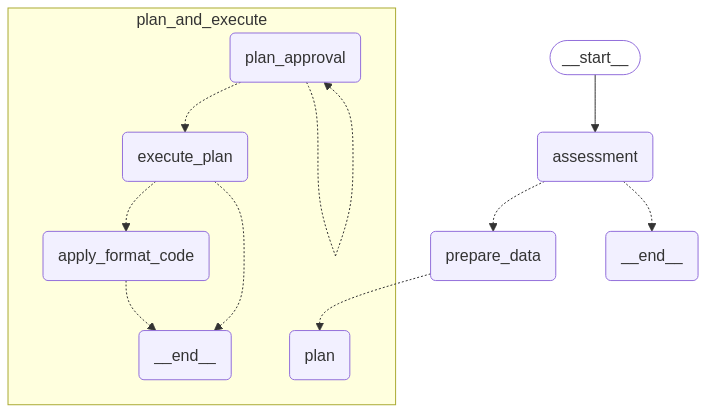

In [2]:
from IPython.display import Image, display  # noqa: A004

display(Image(issue_addressor.draw_mermaid()))

---

## Examples

Here are examples of the issue addressor agent in action. 

### Issue with no code changes

Before the agent is run, the issue is assessed to check if it is a request for code changes.

If it is not, the agent will not plan or execute any changes.

In [38]:
result = issue_addressor.agent.invoke(
    {"issue_title": "Review README.md", "issue_description": "Is the README.md file up to date?"},
    config=config,
    subgraphs=True,
)

In [39]:
print(result[1]["request_for_changes"])

False

### Issue with code changes

When the issue is a request for code changes, the agent will plan the changes to be made and wait for approval before executing them.

In [3]:
result = issue_addressor.agent.invoke(
    {
        "issue_title": "Coverage improvement",
        "issue_description": "Add unittests to cover the file `webhooks/contrib/rest_framework/serializers.py`",
    },
    config=config,
    subgraphs=True,
)

In [4]:
print(result[1]["plan_goal"])
print(result[1]["plan_tasks"])

Implement unit tests to improve code coverage for the webhooks/contrib/rest_framework/serializers.py file. The 
tests should follow the project's existing testing patterns and ensure complete test coverage of the 
BaseCallbackSerializer class, including its validation logic and abstract methods.

[
    Task(
        title='Create test file for serializers',
        description='Create a new test file for the BaseCallbackSerializer in 
webhooks/contrib/rest_framework/serializers.py. The tests will cover validation logic and error handling in the 
serializer.',
        subtasks=[
            'Create a new file webhooks/tests/test_contrib_rest_framework_serializers.py',
            'Add imports for TestCase, patch, MagicMock, and other required modules',
            'Create a TestCase class for BaseCallbackSerializer'
        ],
        path='webhooks/tests/test_contrib_rest_framework_serializers.py',
        context_paths=['webhooks/contrib/rest_framework/serializers.py', 'webhooks/tests/test_forms.py']
    ),
    Task(
        title='Implement test for serializer validation method with missing headers',
        description='Test the validate method of BaseCallbackSerializer when required webhook headers are 
missing.',
        subtasks=[
            'Create a test class that extends BaseCallbackSerializer and sets WEBHOOK_SECRET',
            'Create a test method that mocks a request with missing headers',
            'Verify that ValidationError is raised with the correct message'
        ],
        path='webhooks/tests/test_contrib_rest_framework_serializers.py',
        context_paths=['webhooks/contrib/rest_framework/serializers.py', 'webhooks/constants.py']
    ),
    Task(
        title='Implement test for serializer validation method with invalid signature',
        description="Test the validate method of BaseCallbackSerializer when the provided signature doesn't match 
the generated one.",
        subtasks=[
            'Create a test method that mocks a request with all required headers but an invalid signature',
            'Mock the generate_signature_token function to return a known value',
            'Verify that ValidationError is raised with the correct message about invalid signature'
        ],
        path='webhooks/tests/test_contrib_rest_framework_serializers.py',
        context_paths=['webhooks/contrib/rest_framework/serializers.py', 'webhooks/utils.py']
    ),
    Task(
        title='Implement test for serializer validation method with valid data',
        description='Test the validate method of BaseCallbackSerializer when all headers are valid and the 
signature matches.',
        subtasks=[
            'Create a test method that mocks a request with all valid headers',
            'Mock the generate_signature_token function to return a value matching the provided signature',
            'Verify that validation passes and returns the expected attrs'
        ],
        path='webhooks/tests/test_contrib_rest_framework_serializers.py',
        context_paths=['webhooks/contrib/rest_framework/serializers.py', 'webhooks/utils.py']
    ),
    Task(
        title='Implement tests for abstract methods',
        description='Test that the abstract methods (accept_callback and process_callback) raise 
NotImplementedError when not overridden.',
        subtasks=[
            'Create a test method for accept_callback',
            'Verify that NotImplementedError is raised when called',
            'Create a test method for process_callback',
            'Verify that NotImplementedError is raised when called'
        ],
        path='webhooks/tests/test_contrib_rest_framework_serializers.py',
        context_paths=['webhooks/contrib/rest_framework/serializers.py']
    ),
    Task(
        title='Update the CHANGELOG.md',
        description='Add an entry to the CHANGELOG.md file according to the Keep a Changelog format to document the
addition of tests for the serializers.',
        subtasks=[
            'Add an entry in the [Unreleased] section',
            "Under the 'Added' section, add a note about the new tests for the serializers"
        ],
        path='CHANGELOG.md',
        context_paths=['CHANGELOG.md']
    )
]

Now that i have my plan defined, i need to approve it in order to execute it. The approval must be explicit, otherwise the agent will not execute the plan.

Here an example of a plan that is not explicitly approved:

In [ ]:
result = issue_addressor.agent.invoke(Command(resume=[("human", "Hello DAIV")]), config=config, subgraphs=True)
print(result[1]["plan_approval_response"])

Please provide a response that includes your approval or feedback on the matter at hand.

Now, an example of a plan that is explicitly approved:

In [5]:
result = issue_addressor.agent.invoke(Command(resume=[("human", "I approve the plan")]), config=config, subgraphs=True)

In [6]:
print(result[1]["plan_approval_response"])

KeyError: 'plan_approval_response'

In [7]:
for item in store.search(file_changes_namespace(source_repo_id, source_ref)):
    print(f"============================= {item.key} =============================")
    print(item.value["data"].content)

============================= webhooks/tests/test_contrib_rest_framework_serializers.py 
=============================

from unittest.mock import MagicMock, patch

from django.test import SimpleTestCase

from rest_framework import serializers

from webhooks.choices import WebhookModelOperation
from webhooks.constants import (
    WEBHOOK_HEADER_EVENT,
    WEBHOOK_HEADER_EVENT_SIGNATURE,
    WEBHOOK_HEADER_EVENT_TIMESTAMP,
    WEBHOOK_HEADER_EVENT_UUID,
)
from webhooks.contrib.rest_framework.serializers import BaseCallbackSerializer


class TestBaseCallbackSerializer(SimpleTestCase):
    """Test cases for the BaseCallbackSerializer class."""

    def setUp(self):
        # Create a concrete subclass of BaseCallbackSerializer for testing
        class ConcreteCallbackSerializer(BaseCallbackSerializer):
            WEBHOOK_SECRET = "test_secret"

            def accept_callback(self):
                # Implementation for testing
                pass

            def process_callback(self):
                # Implementation for testing
                pass

        self.serializer_class = ConcreteCallbackSerializer

    def test_validate_missing_headers(self):
        """Test validation when required webhook headers are missing."""
        # Create a serializer instance with a mock request missing headers
        mock_request = MagicMock()
        mock_request.headers = {}

        serializer = self.serializer_class(
            data={"operation": WebhookModelOperation.CREATE}, context={"request": mock_request}
        )

        # Verify serializer is valid but validation raises error
        self.assertTrue(serializer.is_valid())

        with self.assertRaises(serializers.ValidationError) as context:
            serializer.validate(serializer.validated_data)

        # Check error message
        self.assertEqual(str(context.exception.detail[0]), "Missing required headers for the webhook event 
callback.")

    @patch("webhooks.contrib.rest_framework.serializers.generate_signature_token")
    def test_validate_invalid_signature(self, mock_generate_signature):
        """Test validation when the signature is invalid."""
        # Set up mock to return a different signature than what's in the headers
        mock_generate_signature.return_value = "valid_signature"

        # Create a serializer instance with a mock request with all headers but invalid signature
        mock_request = MagicMock()
        mock_request.headers = {
            WEBHOOK_HEADER_EVENT: "test_event",
            WEBHOOK_HEADER_EVENT_UUID: "test_uuid",
            WEBHOOK_HEADER_EVENT_TIMESTAMP: "test_timestamp",
            WEBHOOK_HEADER_EVENT_SIGNATURE: "invalid_signature",
        }

        serializer = self.serializer_class(
            data={"operation": WebhookModelOperation.CREATE}, context={"request": mock_request}
        )

        # Verify serializer is valid but validation raises error for invalid signature
        self.assertTrue(serializer.is_valid())

        with self.assertRaises(serializers.ValidationError) as context:
            serializer.validate(serializer.validated_data)

        # Check error message
        self.assertEqual(str(context.exception.detail[0]), "Invalid signature provided for the webhook event")

        # Verify the generate_signature_token was called with expected arguments
        mock_generate_signature.assert_called_once_with("test_uuid", "test_timestamp", "test_event", "test_secret")

    @patch("webhooks.contrib.rest_framework.serializers.generate_signature_token")
    def test_validate_valid_data(self, mock_generate_signature):
        """Test validation when all data is valid."""
        # Set up mock to return the same signature as what's in the headers
        mock_generate_signature.return_value = "valid_signature"

        # Create test data
        test_data = {"operation": WebhookModelOperation.CREATE}

        # Create a serializer instance with a mock request with all valid headers
        mock_request = MagicMock()
        mock_request.headers = {
            WEBHOOK_HEADER_EVENT: "test_event",
            WEBHOOK_HE

============================= CHANGELOG.md =============================

# Changelog

All notable changes to this project will be documented in this file.

The format is based on [Keep a Changelog](http://keepachangelog.com/en/1.0.0/)
and this project adheres to [Semantic Versioning](http://semver.org/spec/v2.0.0.html).

## [Unreleased]

### Added

- Added unit tests for BaseCallbackSerializer in webhooks/contrib/rest_framework/serializers.py to improve code 
coverage

## [0.3.2] - 2024-08-13

### Fixed

- Another tentative to resolve response not being defined at some circumstances.

## [0.3.1] - 2024-08-13

### Removed

- Removed `authentication_classes` and `permission_classes` from `BaseCallbackView` to allow the user to set it on 
the view.

### Fixed

- Removed `MovementCallbackSerializer` and `WEBHOOK_EVENT_PAYMENTS_MOVEMENT` from `BaseCallbackView`;
- Fixed bug on `send_webhook_request` where `response` could not be defined at some circumstances.

## [0.3.0] - 2024-08-12

### Added

- Added `rest_framework` integration with base view and serializer to help handle callbacks.

### Changed

- Changed `__str__` of models to return more readable information.

### Fixed

- Fixed reponse not being stored on `WebhookEvent` model.

## [0.2.4] - 2024-08-10

### Fixed

- Fixed signals being considered as weak and being garbage collected 
(https://docs.djangoproject.com/en/dev/topics/signals/#:~:text=weak%20%E2%80%93%20Django%20stores%20signal%20handle
rs,the%20signal's%20connect()%20method.)

## [0.2.3] - 2024-08-10

### Fixed

- Fixed signals not being connected.

## [0.2.2] - 2024-08-09

### Added

- Added logging to webhook registry.

### Changed

- Changed all logger to use the same name.

## [0.2.1] - 2024-08-09

### Fixed

- Model dump on payload was generating non-serializable data.

## [0.2.0] - 2024-08-08

### Added

- Webhook event name is sent on the payload of the request too.
- Added constants with header names.

### Changed

- Changed method `generate_signature_token` to generate the signature of the webhook event. The payload was removed
and the event uuid was added to the signature. **BREACKING CHANGE**.
- Admin webhooks list now shows as a `filter_horizontal` on `WebhookSubscriptionAdmin`.

### Fixed

- Payload was being saved in the database as a string, now it is saved as a JSON object.

## [0.1.1] - 2024-07-19

### Fixed

- Serialize payload correctly in post request.

## [0.1.0] - 2024-07-12

### Added

- First commit

[Unreleased]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.2...master
[0.3.2]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.1...v0.3.2
[0.3.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.0...v0.3.1
[0.3.0]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.4...v0.3.0
[0.2.4]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.3...v0.2.4
[0.2.3]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.2...v0.2.3
[0.2.2]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.1...v0.2.2
[0.2.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.0...v0.2.1
[0.2.0]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.1.1...v0.2.0
[0.1.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.1.0...v0.1.1
[0.1.0]: https://git.eurotux.com/dipcode/python/django-webhooks/tree/0.1.0

### Issue with concrete code changes

There are cases where the issue description includes concrete code changes, like a code snippet, a code block, a list of choices, etc... and we need to ensure the agent will include the necessary context in the plan to perform the changes.

Let's see an example:

In [3]:
result = issue_addressor.agent.invoke(
    {
        "issue_title": "New choices for model operations",
        "issue_description": """Add new choices for model operations:
* list - with translation "List"
* get - with translation "Get"
* search - with translation "Search"
* filter - with translation "Filter"
* bulk_create - with translation "Bulk create"
* bulk_update - with translation "Bulk update"
* bulk_delete - with translation "Bulk delete"
""",
    },
    config=config,
    subgraphs=True,
)

In [4]:
print(result[1]["plan_goal"])
print(result[1]["plan_tasks"])

Add new choices for model operations: list, get, search, filter, bulk_create, bulk_update, bulk_delete, each with 
appropriate translations.

[
    Task(
        title='Update WebhookModelOperation class in choices.py',
        description='Add the new choices to the WebhookModelOperation class in webhooks/choices.py following the 
same pattern as the existing choices.',
        subtasks=[
            'Add LIST = "list", _("List") to the WebhookModelOperation class',
            'Add GET = "get", _("Get") to the WebhookModelOperation class',
            'Add SEARCH = "search", _("Search") to the WebhookModelOperation class',
            'Add FILTER = "filter", _("Filter") to the WebhookModelOperation class',
            'Add BULK_CREATE = "bulk_create", _("Bulk create") to the WebhookModelOperation class',
            'Add BULK_UPDATE = "bulk_update", _("Bulk update") to the WebhookModelOperation class',
            'Add BULK_DELETE = "bulk_delete", _("Bulk delete") to the WebhookModelOperation class'
        ],
        path='webhooks/choices.py',
        context_paths=['webhooks/choices.py']
    ),
    Task(
        title='Update CHANGELOG.md',
        description="Add an entry to the CHANGELOG.md file in the Unreleased section to document the new model 
operations following the 'Keep a Changelog' format.",
        subtasks=[
            "Add a new 'Added' section to the Unreleased section if it doesn't exist",
            'Add an entry for the new model operations with appropriate description'
        ],
        path='CHANGELOG.md',
        context_paths=['CHANGELOG.md']
    )
]

In [5]:
result = issue_addressor.agent.invoke(Command(resume=[("human", "I approve the plan")]), config=config, subgraphs=True)

In [6]:
for item in store.search(file_changes_namespace(source_repo_id, source_ref)):
    print(f"============================= {item.key} =============================")
    print(item.value["data"].content)